In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from nbdev import *
%nbdev_default_export training

Cells will be exported to srthesis.training,
unless a different module is specified after an export flag: `%nbdev_export special.module`


In [ ]:
from srthesis.utils import *
select_gpu()

GPUs:2
Selected GPU:1
Available memory:6887MB


# Generator pretraining



In [ ]:
%nbdev_export_internal
import shutil

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

import torch
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter

from srthesis.data import *
from srthesis.loss import *
from srthesis.metrics import *
from srthesis.callbacks import *
from srthesis.model import *



Setting up Perceptual loss...
Loading model from: /home/luslad/thesis/PerceptualSimilarity/models/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


## Config and cleanup

In [ ]:
run_id = 'test_saving_model'

In [ ]:
%nbdev_export_internal
import os
def get_config(run_id):
    
    gen_name = run_id + '-gen'

    path_logging = Path('results/logging/' + gen_name)
    path_tensorboard = Path('results/tensorboard/' + gen_name)
    path_images = Path('results/images/' + gen_name)
    
    path_images.mkdir(parents = True, exist_ok = True)
    
    return gen_name, path_logging, path_tensorboard, path_images



In [ ]:
gen_name, path_logging, path_tensorboard, path_images = get_config(run_id)

In [ ]:
%nbdev_export_internal
def cleanup(run_id:str):
    
    def delete_log_dir(path:str):
        shutil.rmtree(path, ignore_errors=True)

    def clear_log_dir(path:str):
        delete_log_dir(path)
        path.mkdir(exist_ok = True)

    gen_name, path_logging, path_tensorboard, path_images = get_config(run_id)
        
    print(f"Deleting {path_tensorboard}, {path_logging}, clearing {path_images}")
    delete_log_dir(path_tensorboard)
    delete_log_dir(path_logging)
    clear_log_dir(path_images)


In [ ]:
cleanup(run_id)

Deleting results/tensorboard/test_saving_model-gen, results/logging/test_saving_model-gen, clearing results/images/test_saving_model-gen


## Metrics

In [ ]:
%nbdev_export_internal
metrics = [AverageMetric(PSNR), AverageMetric(SSIM), AverageMetric(LPIPS)]

### Callbacks

In [ ]:
%nbdev_export_internal
def _get_tensorboard(learn:Learner, path_tensorboard:Path, gen_name:str, loss_iters=1, visual_iters=1000):
    writer = SummaryWriter(log_dir = path_tensorboard/gen_name)
    tb_cb = ImageGenTensorboardWriter(learn, writer, visual_iters=visual_iters, loss_iters=loss_iters)
    return tb_cb

In [ ]:
%nbdev_export_internal
class CsvLoggerEx(CSVLogger):
    def __init__(self, learn:Learner, path_logging:Path, filename: str = 'history', append: bool = False): 
        super().__init__(learn, filename, append)
        self.path = path_logging / filename

In [ ]:
%nbdev_export_internal
class SaveEveryNIterations(LearnerCallback):
    def __init__(self, learn:Learner, save_iters:int = 100):
        super().__init__(learn)
        self.save_iters = save_iters
        self.times_saved = 0
        self.prev_iterations = 0     
    
    def on_epoch_end(self, iteration:int, **kwargs)->None:
        if (self.prev_iterations + iteration) // self.save_iters > self.times_saved:
            self.times_saved += 1
            self.save(self.prev_iterations + iteration)
            
    def on_train_end(self, iteration:int, **kwargs)->None:
        "Keep track of total numbers of iterations"
        self.prev_iterations += iteration 
        
    def save(self, iteration:int):
        raise NotImplementedError("Implement save method")

In [ ]:
%nbdev_export_internal
class SavePredsCallback(SaveEveryNIterations):
    """Save selected patches every save_iters iteration. Triggered after epoch"""
    def __init__(self, learn:Learner, fnames:List[str], save_dir:Path, save_iters:int = 100):
        super().__init__(learn, save_iters)
        self.fnames = fnames
        self.save_dir = save_dir
        
    def save(self, iteration:int):
        for fn in self.fnames:
            img_lr = open_image(fn)
            tg = self.learn.predict(img_lr)
            tg[0].save(self.save_dir/(str(self.times_saved) + '-' + fn.name.replace('LR2','PRED')))

In [ ]:
%nbdev_export_internal
class SaveModelEveryItersCallback(SaveEveryNIterations):
    
    def __init__(self, learn:Learner, save_iters:int=50000, run_id:str='default'):
        super().__init__(learn, save_iters)
        self.name = run_id        
    
    def jump_to_iter(self, iteration:int)->None:
        try:
            self.learn.load(f'{self.name}_{iteration-1}', purge=False)
            print(f"Loaded {self.name}_{iteration-1}")
        except: print(f'Model {self.name}_{iteration-1} not found.')
          
    def save(self, iteration:int):
        print(f"Saving model checkpoint to {f'{self.name}_{iteration}'}")
        self.learn.save(f'{self.name}_{iteration}')

In [ ]:
%nbdev_export_internal
class SaveResultsFigure(SaveEveryNIterations):
    def __init__(self, learn:Learner, path:Path, name:str='figure', save_iters:int=10000):
        super().__init__(learn, save_iters)
        self.name = name
        self.path = path
        
    def save(self, iteration:int):
        fname = f"Fig-{self.name}_{self.prev_iterations + iteration}.png"
        fpath = self.path / fname
        print(f"Saving results to {fname}")
        self.learn.show_results(rows=1, imgsize=5)
        plt.savefig(fpath)
        plt.close('all')

In [ ]:
%nbdev_export_internal
def _get_callbacks(learn:Learner, 
                   run_id:str,
                   visual_iters:int = 10000,
                   loss_iters:int = 100,
                   checkpoint_every=10000):
    gen_name, path_logging, path_tensorboard, path_images = get_config(run_id)
    
    tb_cb = _get_tensorboard(learn, path_tensorboard, gen_name, loss_iters=loss_iters, visual_iters = visual_iters)
    csv_logger = CsvLoggerEx(learn, path_logging, 'log-' + gen_name + '.csv', True)
    save_img = SavePredsCallback(learn, test_patches, save_dir = path_images, save_iters=visual_iters)
    save_model = SaveModelEveryItersCallback(learn, name=gen_name, save_iters=checkpoint_every)
    save_results = SaveResultsFigure(learn, path=path_images, name=gen_name, save_iters=5000)
    return [tb_cb, csv_logger, save_img, save_model, save_results]

In [ ]:
class TrainingManager(LearnerCallback):
    def __init__(self, run_id:str, start_epoch:int=1, resume_from_last=False):
        self.start_epoch = start_epoch
        
    def on_train_begin(self, **kwargs):
        print(kwargs)
        ret = {'epoch':self.start_epoch}

        return ret
    
    def on_epoch_end(self, iteration, **kwargs):
        print(iteration)

## Training loop

In [ ]:
%nbdev_export_internal
def train_model(run_id:str, 
                       learn:Learner, 
                       lr = 2e-4, #initial lr, halved every phase_len iters
                       n_phases = 5, # lr halved after every phase
                       phase_len = 1e5, # in iterations
                       checkpoint_every: int = 10000, 
                       visual_iters:int = 5000,
                       loss_iters:int = 100,
                       pretraining=True):
    gen_name = run_id + '-gen'
    
    cb = _get_callbacks(learn, run_id, checkpoint_every=checkpoint_every, visual_iters=visual_iters, loss_iters=loss_iters)
    
    #initial transfer learning]
    if pretraining:
        print(f"Pretraining for 10 steps with lr=1e-3")
        learn.fit_one_cycle(10, 1e-3, pct_start=0.9, callbacks=cb)
        
    learn.unfreeze()
    
    #lr scheduler
    phases = [(TrainingPhase(phase_len)
                 .schedule_hp('lr', lr // (2**i), anneal=annealing_no)) for i in range(n_phases)]
    cb.append(GeneralScheduler(learn, phases))
    
    #number of epochs determined by lr scheduler
    n = len(learn.data.train_dl)
    epochs = int(n_phases * phase_len) // n
        
    print(f"Batches in epoch: {n}")
    print(f"Total iters: {n_phases * phase_len}")
    print(f"Training will run for {epochs} epochs.")
    
    learn.fit_one_cycle(epochs, pct_start=0.3, callbacks=cb)
    

# Test it 

## Data

In [ ]:
data = get_data(128, 16, dataset='realsr_inverse', repeat_train=1, max_train_len = 16)
data

Data: Iters in epoch: 1, loading threads: 1


ImageDataBunch;

Train: LabelList (16 items)
x: CachedImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CachedImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: datasets/RealSR/Canon;

Valid: LabelList (30 items)
x: CachedImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CachedImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: datasets/RealSR/Canon;

Test: None

CPU times: user 6.64 s, sys: 2 s, total: 8.63 s
Wall time: 3.49 s


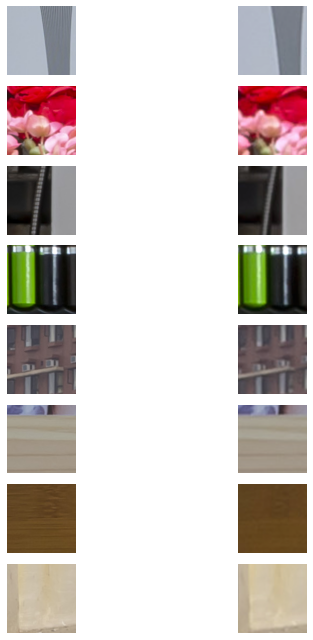

In [ ]:
%%time
data.show_batch(ds_type=DatasetType.Valid, rows=8, figsize=(9,9))

Batches in epoch: 1
Training will run for 20 epochs.
{'epoch': 0, 'iteration': 0, 'num_batch': 0, 'skip_validate': False, 'n_epochs': 20, 'pbar': <fastprogress.fastprogress.NBMasterBar object at 0x7f22f0042910>, 'metrics': [AverageMetric
func: <function denormalize.<locals>._denormalized at 0x7f23555a39e0>, AverageMetric
func: <function denormalize.<locals>._denormalized at 0x7f23555a3cb0>, AverageMetric
func: <function denormalize.<locals>._denormalized at 0x7f22f2d0db00>], 'metrics_names': ['psnr', 'ssim', 'LPIPS', 'pixel', 'feat_0', 'feat_1', 'feat_2']}


epoch,train_loss,valid_loss,psnr,ssim,LPIPS,pixel,feat_0,feat_1,feat_2,time
6,22.047697,26.774702,24.668604,0.892014,0.070190,0.222287,0.638458,0.937355,0.311596,00:12
7,26.256388,29.261950,24.227255,0.875020,0.090593,0.226395,0.662073,0.992637,0.383854,00:10
8,27.518255,24.872669,25.448498,0.899318,0.065043,0.189327,0.620934,0.905051,0.336755,00:11
9,27.643501,24.416508,27.390223,0.912975,0.048702,0.144872,0.604098,0.902916,0.351947,00:11
10,26.904266,22.283813,29.877062,0.924794,0.049008,0.111035,0.591175,0.867966,0.306378,00:11
11,26.599443,26.691565,28.517708,0.919217,0.051765,0.136054,0.628099,0.950358,0.334781,00:10
12,26.600754,23.341503,28.731733,0.919028,0.043031,0.131099,0.595258,0.880017,0.279639,00:11
13,26.392475,23.789721,28.655169,0.918311,0.047451,0.129519,0.600869,0.888407,0.357125,00:10
14,26.221628,22.691969,28.432251,0.927164,0.043854,0.132183,0.603253,0.874806,0.322709,00:11
15,25.738846,22.326366,27.568880,0.915565,0.053108,0.145349,0.617764,0.885451,0.339322,00:10


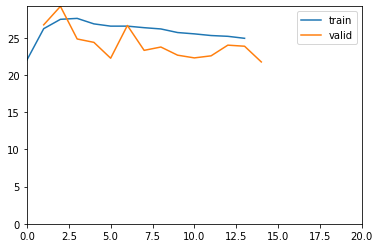

1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [ ]:
learn = learn_gen 
learn.data = data
lr = 2e-4 #initial lr, halved every phase_len iters
n_phases = 5 # lr halved after every phase
phase_len = 1e5 # in iterations
checkpoint_every= 10000
visual_iters= 5000
loss_iters= 100
pretraining=True

sz = 128
bs = 16


gen_name = run_id + '-test'

cb = _get_callbacks(learn, run_id, checkpoint_every=checkpoint_every, visual_iters=visual_iters, loss_iters=loss_iters)
#cb = []
#initial transfer learning]
learn.unfreeze()

#lr scheduler
#phases = [(TrainingPhase(phase_len)
#             .schedule_hp('lr', lr // (2**i), anneal=annealing_no)) for i in range(n_phases)]
#cb.append(GeneralScheduler(learn, phases))
cb.append(PrintStateCb(learn))

#number of epochs determined by lr scheduler
n = len(learn.data.train_dl)
epochs = 20

print(f"Batches in epoch: {n}")
print(f"Training will run for {epochs} epochs.")

learn.fit(epochs, callbacks=cb)


In [ ]:
data.dls

[DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7ff125d31a10>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7ff12983c170>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=True)], collate_fn=<function data_collate at 0x7ff129f885f0>),
 DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7ff125d31b50>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7ff12983c170>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=True)], collate_fn=<function data_collate at 0x7ff129f885f0>),
 DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7ff125d31c10>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7ff12983c170>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=True)], collate_fn=<function data_

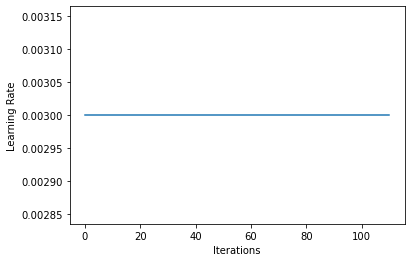

In [ ]:
learn.recorder.plot_lr()

## Learner for testing

In [ ]:
%nbdev_export_internal
def create_learner(data:ImageDataBunch, 
                   arch = models.resnet34,
                   regularizations=True,
                   wd = 1e-3,
                   loss_func=FeatureLoss(layer_wgts=[5,15,2]),
                   metrics=[AverageMetric(PSNR), AverageMetric(SSIM), AverageMetric(LPIPS)],
                   pretrained=True,
                   callback_fns=[LossMetrics], **kwargs):
    if regularizations:
        norm_type = NormType.Weight
        wd = wd
    else:
        norm_type = None
        wd = None
    
    learn_gen = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=metrics, pretrained=pretrained, 
                             callback_fns=[LossMetrics, ShowGraph],
                             blur=True, norm_type=NormType.Weight, **kwargs)
    learn_gen.path = data.path
    return learn_gen
    

In [ ]:
learn_gen = create_learner(data, arch = models.resnet34, bottle=False, regularizations=True)

In [ ]:
#learn_gen.unfreeze()
#learn_gen.summary()

## Run experiment

In [ ]:
%nbdev_export
def run_experiment(run_id='default', 
                   dataset='realsr', 
                   dihedral_augs=True, 
                   pretraining=True, 
                   visual_iters:int = 5000,
                   loss_iters:int = 100,
                   checkpoint_every=5000,
                   repeat_train:int = 10,
                   max_train_len:int=sys.maxsize):
    gen_name, path_logging, path_tensorboard, path_images = get_config(run_id)
    cleanup(run_id)
    
    print(f"Experiment: {run_id}")
    
    sz = 128
    bs = 16
    
    data = get_data(sz, bs, 
                    dataset=dataset, 
                    dihedral_augs=dihedral_augs, 
                    repeat_train=repeat_train,
                    max_train_len=max_train_len)
    
    print("Data \n:" + str(data))
    #data.show_batch()
    #plt.show()
    
    learn_gen = create_learner(data, pretrained=pretraining)
    
    train_model(run_id, learn_gen, checkpoint_every=checkpoint_every,  pretraining=pretraining)
    

In [ ]:
%nbdev_export
def run_overfitting(run_id='default_overfit',
                   visual_iters:int = 5000,
                   loss_iters:int = 100,
                   checkpoint_every:int = 50000,
                   repeat_train:int = 1500,
                   max_train_len:int = 1):
    
    kwargs = locals()
    kwargs['dataset'] = 'realsr'
    kwargs['dihedral_augs'] = False
    kwargs['pretraining'] = False
    
    run_experiment(**kwargs)
    
    

In [ ]:
run_overfitting()

NameError: name 'run_overfitting' is not defined

In [ ]:
%nbdev_export
def train_degradation_model(run_id='default'):
    run_experiment(run_id, dataset='realsr_inverse', repeat_train=10)
    

In [ ]:
import multiprocessing 

def _validate(model:nn.Module, dl:DataLoader, loss_func:OptLossFunc=None, cb_handler=None,
             pbar=None, average=True, n_batch:Optional[int]=None):
    "Calculate `loss_func` of `model` on `dl` in evaluation mode."
    print("_validate called")
    
    t = time.process_time()
    model.eval()
    #print(f"Time valid:model.eval(): {time.process_time() - t}")
    
    with torch.no_grad():
        val_losses,nums = [],[]
        
        t1 = time.process_time()
        if cb_handler: cb_handler.set_dl(dl)
        #print(f"Time valid:set_dl: {time.process_time() - t}")
        
        for xb,yb in dl:
            t = time.process_time()
            if cb_handler: xb, yb = cb_handler.on_batch_begin(xb, yb, train=False)
            #print(f"Time valid:on_batch_begin (xb, yb): {time.process_time() - t}")
            
            #t = time.process_time()
            val_loss = loss_batch(model, xb, yb, loss_func, cb_handler=cb_handler)
            print(f"Time valid:loss_batch + batch_begin: {time.process_time() - t}")
            
            t = time.process_time()
            
            val_losses.append(val_loss)
            if not is_listy(yb): yb = [yb]
            nums.append(first_el(yb).shape[0])
            
            
            if cb_handler and cb_handler.on_batch_end(val_losses[-1]): break
            print(f"Time valid:append_results + on_batch_end: {time.process_time() - t}")
            
            if n_batch and (len(nums)>=n_batch): break
                
        print(f"Time valid:total: {time.process_time() - t1}")
        nums = np.array(nums, dtype=np.float32)
        if average: return (to_np(torch.stack(val_losses)) * nums).sum() / nums.sum()
        else:       return val_losses

def _logged_fit(epochs:int, learn, callbacks:Optional[CallbackList]=None, metrics:OptMetrics=None)->None:
    "Fit the `model` on `data` and learn using `loss_func` and `opt`."
    assert len(learn.data.train_dl) != 0, f"""Your training dataloader is empty, can't train a model.
        Use a smaller batch size (batch size={learn.data.train_dl.batch_size} for {len(learn.data.train_dl.dataset)} elements)."""
    print("_logged_fit called")
    
    cb_handler = CallbackHandler(callbacks, metrics)
    pbar = master_bar(range(epochs))
    
    t = time.process_time()
    cb_handler.on_train_begin(epochs, pbar=pbar, metrics=metrics)
    print(f"Time on_train_begin: {time.process_time() - t}")
    
    exception=False
    try:
        for epoch in pbar:
            learn.model.train()
            cb_handler.set_dl(learn.data.train_dl)
            cb_handler.on_epoch_begin()
            tt = time.process_time()
            print(f"{len(multiprocessing.active_children())} processes")
            for xb,yb in learn.data.train_dl:
                
                t = time.process_time()
                xb, yb = cb_handler.on_batch_begin(xb, yb)
                #print(f"Time xb, yb: {time.process_time() - t}")

                #t = time.process_time()
                loss = loss_batch(learn.model, xb, yb, learn.loss_func, learn.opt, cb_handler)
                #print(f"Time loss_batch: {time.process_time() - t}")
                #t = time.process_time()
                if cb_handler.on_batch_end(loss): break
                print(f"Time train:on_batch_end: {time.process_time() - t}") 
                print(f"{len(multiprocessing.active_children())} processes")
                
            print(f"Time train:epoch_time: {time.process_time() - tt}")
            print(f"{len(multiprocessing.active_children())} processes")
            t = time.process_time()
            if not cb_handler.skip_validate and not learn.data.empty_val:
                print("Validate")
                val_loss = _validate(learn.model, learn.data.valid_dl, loss_func=learn.loss_func,
                                       cb_handler=cb_handler, pbar=pbar)
            else: val_loss=None
            print(f"Time val_loss: {time.process_time() - t}")    
            
            t = time.process_time()
            if cb_handler.on_epoch_end(val_loss): break
            print(f"Time on_epoch_end: {time.process_time() - t}")        
    except Exception as e:
        exception = e
        raise
    finally: cb_handler.on_train_end(exception)
        
def _fit(self, epochs:int, lr=defaults.lr,
            wd:Floats=None, callbacks:Collection[Callback]=None)->None:
        "Fit the model on this learner with `lr` learning rate, `wd` weight decay for `epochs` with `callbacks`."
        print("_fit called")
        lr = self.lr_range(lr)
        if wd is None: wd = self.wd
        if not getattr(self, 'opt', False): self.create_opt(lr, wd)
        else: self.opt.lr,self.opt.wd = lr,wd
        callbacks = [cb(self) for cb in self.callback_fns + listify(defaults.extra_callback_fns)] + listify(callbacks)
        _logged_fit(epochs, self, metrics=self.metrics, callbacks=self.callbacks+callbacks)

In [ ]:
import types

learn_gen.fit = types.MethodType(_fit, learn_gen)


In [ ]:
learn_gen.metrics = []
learn_gen.callback_fns = []

In [ ]:
data.batch_size

16

epoch,train_loss,valid_loss,psnr,ssim,LPIPS,pixel,feat_0,feat_1,feat_2,time
0,16.965565,17.759106,31.939543,0.949996,0.028540,0.085031,0.533334,0.740912,0.258673,01:10
1,17.570503,18.507376,31.016052,0.939498,0.032461,0.092400,0.559492,0.755402,0.275579,01:13
2,18.687189,17.719582,30.880505,0.948331,0.033032,0.096508,0.536535,0.729336,0.245131,01:10
3,18.411722,19.661854,29.637341,0.938214,0.035721,0.111891,0.548738,0.781144,0.299783,01:13
4,17.761181,18.151632,30.476025,0.944278,0.031245,0.101533,0.551100,0.771466,0.264230,01:11
5,17.632967,17.503407,30.653807,0.948686,0.031366,0.093185,0.529551,0.733167,0.237395,01:13
6,17.148237,17.703573,31.722164,0.947039,0.033272,0.085579,0.545431,0.757089,0.276484,01:12


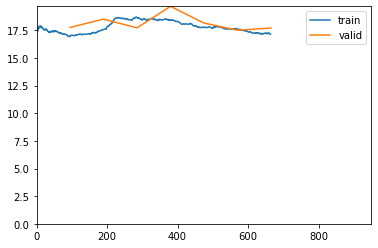

Exception ignored in: <function _releaseLock at 0x7f00e468eb90>
Traceback (most recent call last):
  File "/home/luslad/miniconda3/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


RuntimeError: DataLoader worker (pid(s) 22621, 22622, 22623, 22626, 22627, 22628, 22629, 22630, 22633, 22634, 22635, 22636, 22638, 22641, 22642, 22643, 22644, 22661, 22662) exited unexpectedly

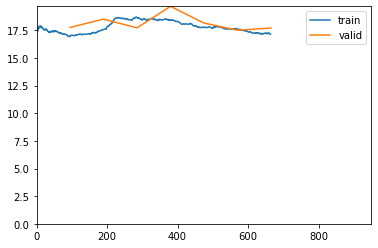

In [ ]:
gen_name, path_logging, path_tensorboard, path_images = get_config(run_id)
learn_gen.data = data
learn_gen.fit_one_cycle(10, pct_start=0.3, callbacks=[])

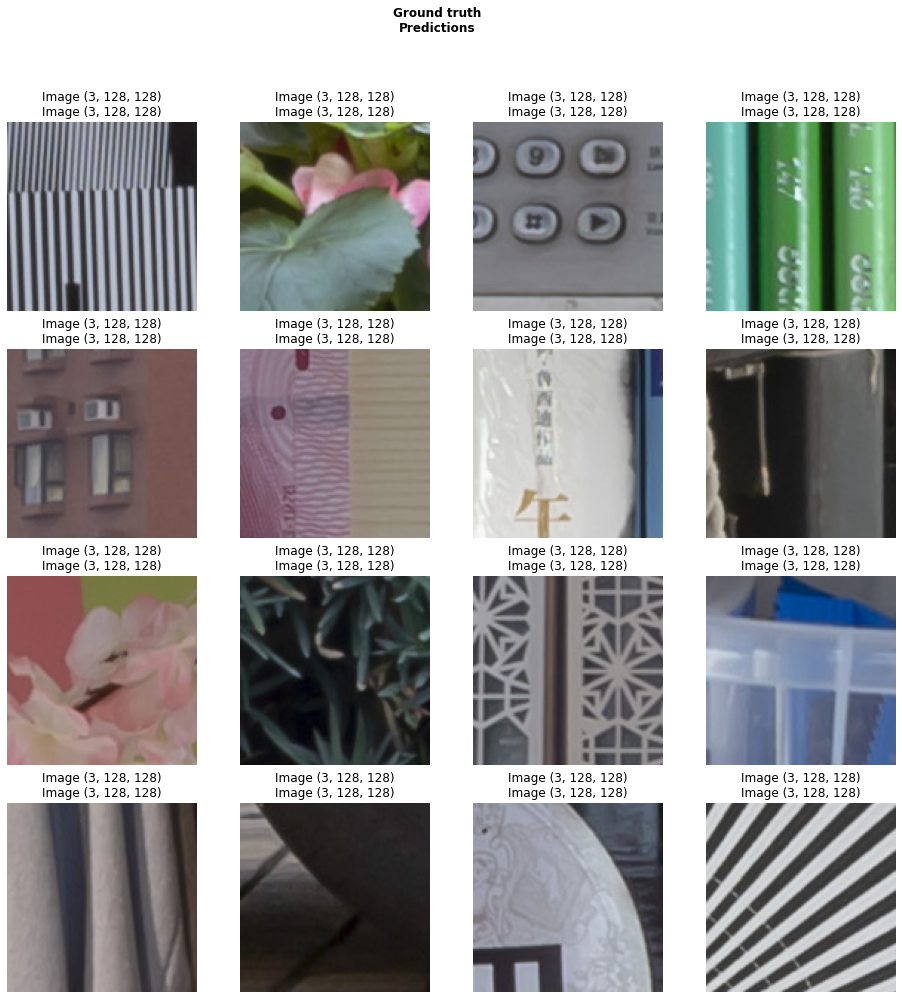

In [ ]:
learn_gen.show_results()

Deleting results/tensorboard/default-gen, results/logging/default-gen, clearing results/images/default-gen
Experiment: default
Data 
:ImageDataBunch;

Train: LabelList (153 items)
x: CachedImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CachedImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: datasets/RealSR/Canon;

Valid: LabelList (30 items)
x: CachedImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CachedImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: datasets/RealSR/Canon;

Test: None
Pretraining for 10 steps with lr=1e-3


epoch,train_loss,valid_loss,psnr,ssim,LPIPS,pixel,feat_0,feat_1,feat_2,time
0,59.636234,56.737679,14.301113,0.336032,0.498958,0.688556,1.180325,1.640489,0.603832,00:28
1,58.753109,55.013046,14.699557,0.341888,0.478186,0.645053,1.189786,1.603018,0.578941,00:21
2,56.710468,46.974312,15.324111,0.376300,0.447475,0.576134,1.095647,1.489379,0.537743,00:20


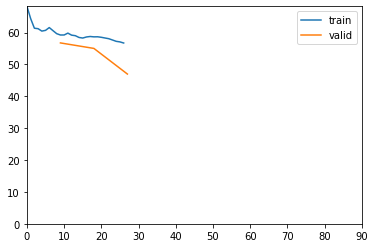

KeyboardInterrupt: 

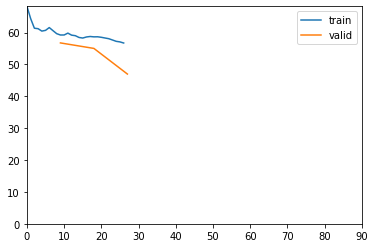

In [ ]:
train_degradation_model()

Batches in epoch: 9
Total iters: 500000.0
Training will run for 55555 epochs.


epoch,train_loss,valid_loss,psnr,ssim,LPIPS,pixel,feat_0,feat_1,feat_2,time
0,60.813324,59.875298,10.256034,0.107681,0.731566,1.123234,1.367783,1.698883,0.636624,00:24
1,60.592922,56.472031,13.053296,0.257964,0.477082,0.791120,1.299803,1.597010,0.666804,00:18


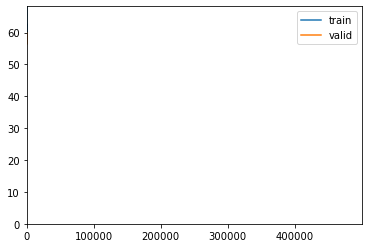

KeyboardInterrupt: 

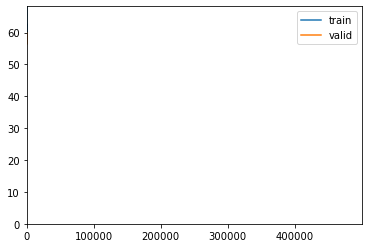

In [ ]:
gc.collect();
#test_run(learn_gen, epochs = 4)
train_model(run_id, learn_gen, pretraining=False)

In [ ]:
%nbdev_hide
notebook2script()

Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted 0__template.ipynb.
Converted 10_data.ipynb.
Converted 11_div2k.ipynb.
Converted 12_realsr.ipynb.
Converted 20_metrics.ipynb.
Converted 21_loss.ipynb.
Converted 22_callbacks.ipynb.
Converted 23_tensorboard.ipynb.
Converted 31_generator_learner.ipynb.
Converted 32_critic_learner.ipynb.
Converted 41_generator_pretraining.ipynb.
Converted 42_critic_pretraining.ipynb.
Converted 43_gan_training.ipynb.
Converted augmentations.ipynb.
Converted graphs-tests.ipynb.
Converted sr reference.ipynb.
